In [73]:
# use print only as a function
from __future__ import print_function
import sys
#sys.version_info
#pd.show_versions()  ## This will show all of the installed packages

In [74]:
__author__ = 'swe03'

import argparse

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as pplt
from decimal import *

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from statsmodels.graphics.api import qqplot

from scipy import stats

desired_width = 400
pd.set_option('display.width',desired_width)

In [75]:
#!pip install seaborn

In [76]:
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [77]:
#!pip install pandasql
from pandasql import PandaSQL 
pdsql = PandaSQL()

##### Read the BQ tables created in the Dst Addr and Port profile 1 or Iterate and Create ADS's 1 programs

In [78]:
#!pip install google-api-python-client
#ent_calc_df1 = pd.read_gbq("select * from prod.calc_ent2_3wks", project_id="network-sec-analytics")
ent_calc_df1 = pd.read_gbq("select * from prod.calc_ent3_3wks", project_id="network-sec-analytics")
#ent_calc_df1[250:310]

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 1; 100.0% done. Elapsed 9.46 s.
Got 504 rows.

Total time taken 9.47 s.
Finished at 2017-05-09 20:59:08.


In [79]:
#Need a DateTime Index for all of the time series modeling functions.
#Note in the output from ent_calc_df1.index.dtype: dtype('<M8[ns]') but...  np.dtype('datetime64[ns]') = np.dtype('<M8[ns]'):
ent_calc_df1.reset_index(inplace=True)
ent_calc_df1 = ent_calc_df1.set_index('date_hour')
ent_calc_df1.sort_index(inplace=True)
#ent_calc_df1.index
#ent_calc_df1

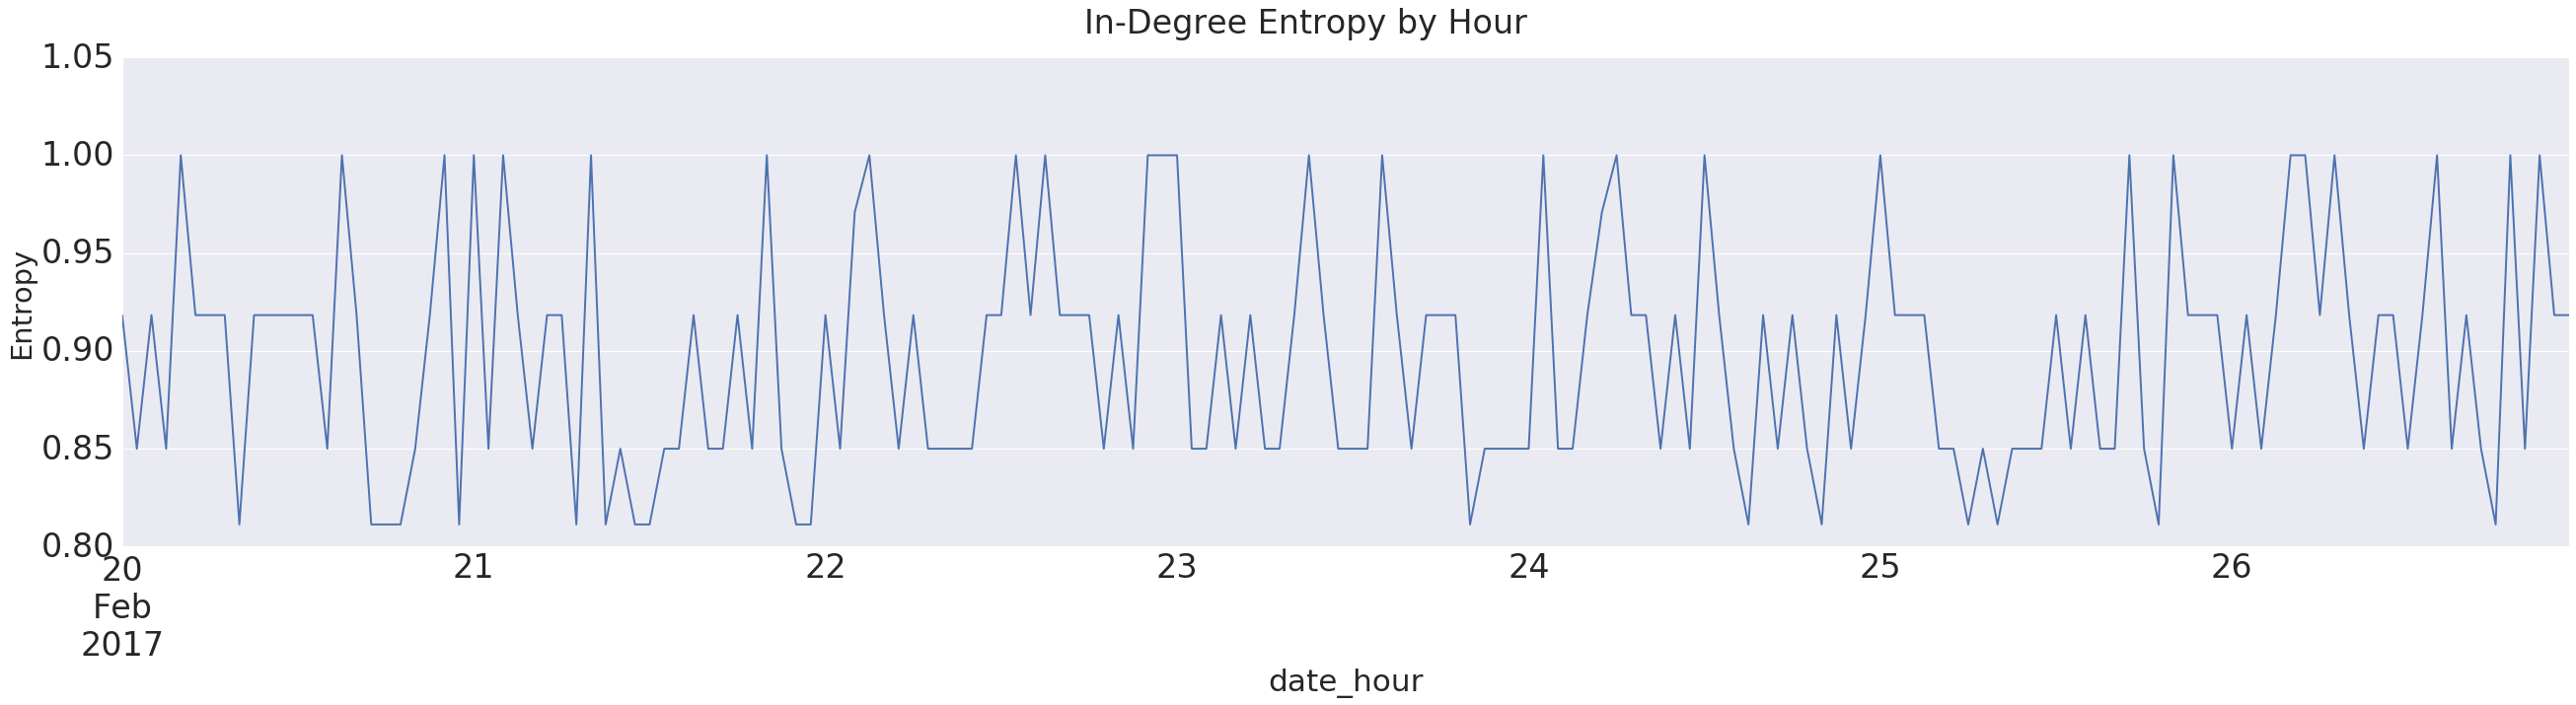

In [80]:
####### Graph to just plot a Range (or ALL) of Entropy Values directly from the df ########
####### figsize(x-axis length, y-axis length)

fig, ax = plt.subplots(figsize=(9,4))  ## Changing these settings didn't seem to do anything other then change the color 

fig.suptitle('In-Degree Entropy by Hour', fontsize=30)
plt.xticks(rotation=80)  # Not working
plt.xlabel('Hour', fontsize=28)   # The fontsize here is applied to the variable name not the label in the function
plt.ylabel('Entropy', fontsize=26)

# fontsize is just for the axes size
ent_calc_df1['In_degree_entropy'].ix['2017-02-20 00:00:00':'2017-02-26 23:00:00'].plot(figsize=(40,8), fontsize=30)  

##### Execute some Univariate Statistics

In [81]:
#ent_calc_df1['unq_src_dst_addr_cnt'].describe()
ent_calc_df1['In_degree_entropy'].describe()

count    504.000000
mean       0.900697
std        0.060764
min        0.721928
25%        0.850000
50%        0.918296
75%        0.918296
max        1.000000
Name: In_degree_entropy, dtype: float64

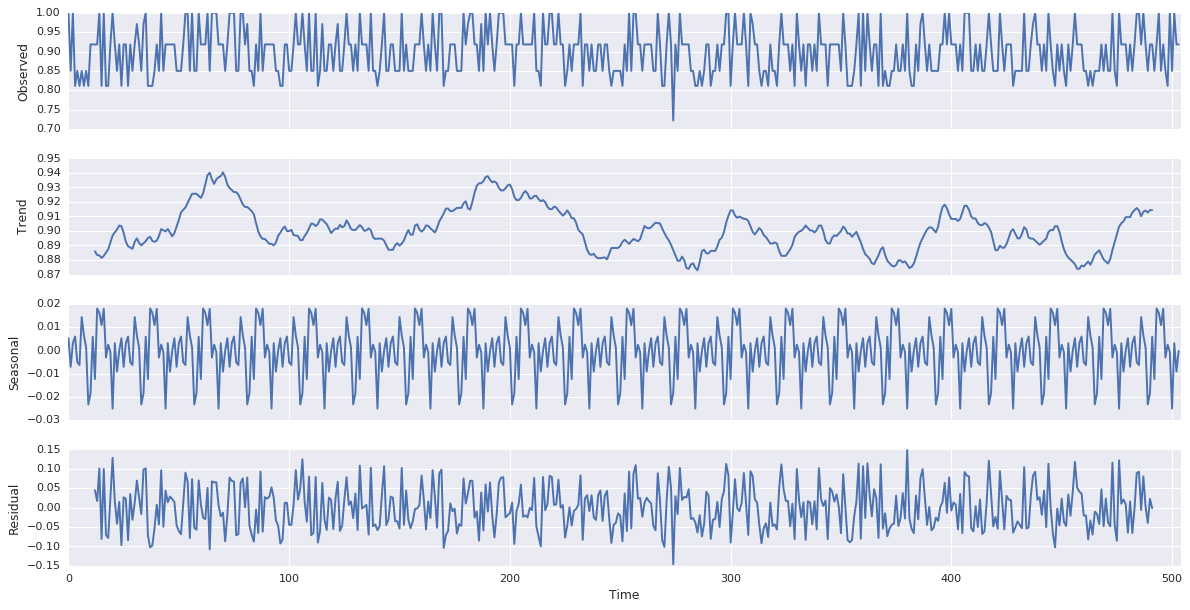

In [82]:
decomposition = seasonal_decompose(ent_calc_df1['In_degree_entropy'].values,freq=24)  
  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

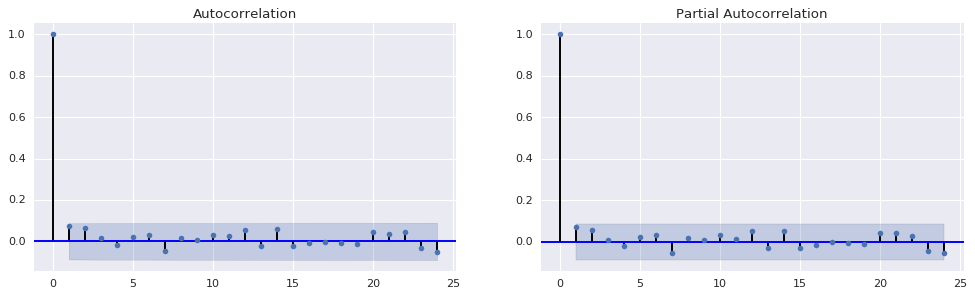

In [83]:
# Graph Autocorrelation and Partial Autocorrelation data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(ent_calc_df1['In_degree_entropy'], lags=24, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(ent_calc_df1['In_degree_entropy'], lags=24, ax=axes[1])

In [84]:
## Specify the SARIMAX model
## Default for the CI is 95%.  Set in the Alpha parameter for conf_int function
mod = sm.tsa.statespace.SARIMAX(ent_calc_df1['In_degree_entropy'], 
         order=(2,0,1), seasonal_order=(3,0,0,24))
mod1 = sm.tsa.statespace.SARIMAX(ent_calc_df1['In_degree_entropy'], 
      order=(8,0,0), seasonal_order=(2,0,0,6))
mod2 = sm.tsa.statespace.SARIMAX(ent_calc_df1['In_degree_entropy'], 
     trend='n', order=(1,0,0), seasonal_order=(2,0,0,24))
results = mod.fit()
print(results.summary())                                

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                  In_degree_entropy   No. Observations:                  504
Model:             SARIMAX(2, 0, 1)x(3, 0, 0, 24)   Log Likelihood                 570.355
Date:                            Tue, 09 May 2017   AIC                          -1126.710
Time:                                    21:00:58   BIC                          -1097.152
Sample:                                02-06-2017   HQIC                         -1115.115
                                     - 02-26-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1069      0.037     30.278      0.000       1.035       1.179
ar.L2         -0.1073      0.035   

#### Post Model Goodness of Fit Assessments

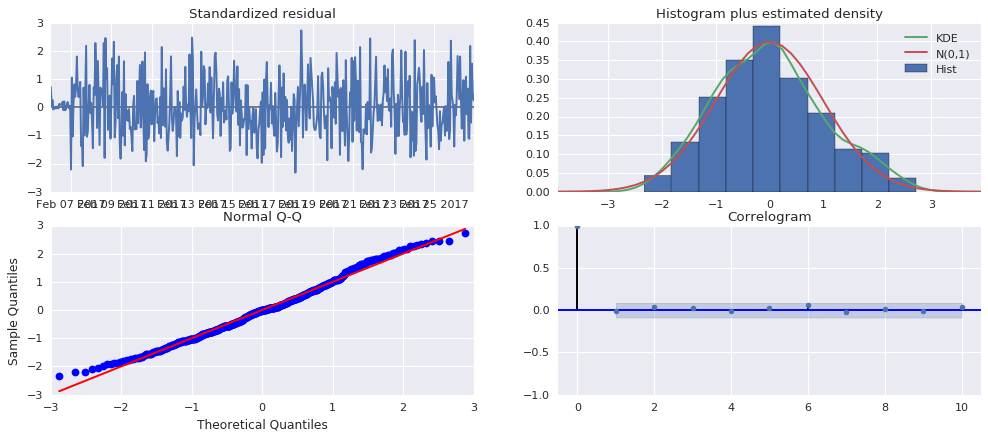

In [85]:
fig = results.plot_diagnostics()

In [86]:
## Check to see if Residuals are still correlated
## Values are between 0 and 4.  Values close to 2: no Serial Correlation. Close to 0: Pos Corr. Close to 4: Neg Corr.
sm.stats.durbin_watson(results.resid.values)

1.7195810882414624

In [87]:
## Check to see if the distributionb of Residuals are Normally Distributed (i.e., This is undesirable)
##If the p-val is very small, it means it is unlikely that the data came from a normal distribution
resid1 = results.resid
stats.normaltest(resid1)

NormaltestResult(statistic=438.93732561685272, pvalue=4.8525586328254543e-96)

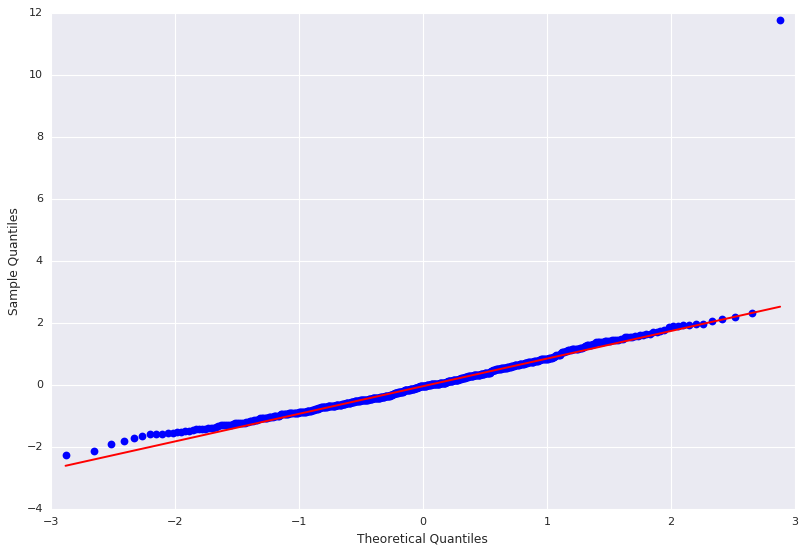

In [88]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid1, line='q', ax=ax, fit=True)

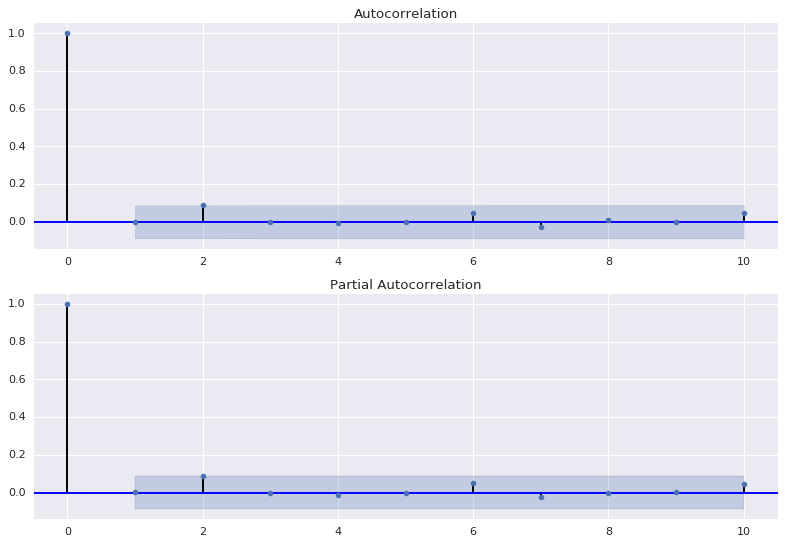

In [89]:
# Graph the acf and pacf for the Residuals
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid1.values.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid1, lags=10, ax=ax2)

In [90]:
# Box-Pierce Q statistic tests the Null Ho that *ALL* correlations up to Lag K are equal to Zero.  This is not the 
# same as the correlogram above.
r,q,p = sm.tsa.acf(resid1.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0   0.001430   0.001036  0.974317
2.0   0.089215   4.044473  0.132359
3.0  -0.001695   4.045936  0.256546
4.0  -0.005301   4.060266  0.397911
5.0  -0.001389   4.061252  0.540631
6.0   0.046587   5.172672  0.521865
7.0  -0.025876   5.516257  0.597224
8.0   0.007256   5.543329  0.698235
9.0  -0.001785   5.544972  0.784453
10.0  0.044486   6.566641  0.765625
11.0  0.032839   7.124485  0.788915
12.0  0.077272  10.219466  0.596714
13.0 -0.016909  10.367975  0.663602
14.0  0.078556  13.579710  0.481469
15.0 -0.025600  13.921492  0.531492
16.0 -0.000075  13.921495  0.604562
17.0  0.011536  13.991185  0.667726
18.0 -0.007618  14.021638  0.727680
19.0  0.009571  14.069808  0.779607
20.0  0.077772  17.256836  0.636239
21.0  0.041983  18.187458  0.637112
22.0  0.010448  18.245216  0.691354
23.0 -0.003077  18.250235  0.743778
24.0 -0.117032  25.527231  0.377580
25.0  0.006618  25.550548  0.431884
26.0  0.002461  25.553779  0

#### Prediction and Forecasting Section

In [91]:
# This is just a SARIMAX Results Wrapper.  It collects the model parameters for later use.
res = mod.filter(results.params)

In [92]:
### In-sample prediction and out-of-sample forecasting
### predict() with no parameters will produce just In-sample predictions
### With index based Start/End, must start at less than or equal to Length of training data 
###   (zero based index: 504 records, last rec is 503)
### Can only use dates if index is datetime.

#predict_res = res.predict(alpha=.05, start=503, end=510)    ## 2017-02-26 23:00:00 is 503
#print(predict_res)

#predict_res = res.predict(alpha=.05, start='2017-02-26 00:00:00', end='2017-02-27 01:00:00') # Note limited range
predict_res = res.predict()
predict_res

2017-02-06 00:00:00    0.000000
2017-02-06 01:00:00    0.797215
2017-02-06 02:00:00    0.801378
2017-02-06 03:00:00    0.872571
2017-02-06 04:00:00    0.839006
2017-02-06 05:00:00    0.845122
2017-02-06 06:00:00    0.835840
2017-02-06 07:00:00    0.841857
2017-02-06 08:00:00    0.834146
2017-02-06 09:00:00    0.839952
2017-02-06 10:00:00    0.833091
2017-02-06 11:00:00    0.851920
2017-02-06 12:00:00    0.857188
2017-02-06 13:00:00    0.861681
2017-02-06 14:00:00    0.865558
2017-02-06 15:00:00    0.882946
2017-02-06 16:00:00    0.858373
2017-02-06 17:00:00    0.886676
2017-02-06 18:00:00    0.862366
2017-02-06 19:00:00    0.859760
2017-02-06 20:00:00    0.874102
2017-02-06 21:00:00    0.888835
2017-02-06 22:00:00    0.882609
2017-02-06 23:00:00    0.885683
2017-02-07 00:00:00    0.999061
2017-02-07 01:00:00    0.829529
2017-02-07 02:00:00    1.006013
2017-02-07 03:00:00    0.802607
2017-02-07 04:00:00    0.849648
2017-02-07 05:00:00    0.818778
                         ...   
2017-02-

In [93]:
### In-sample prediction and out-of-sample forecasting

### The predict function works is the same as above res.predict() except that exogenous variables can be 
###   included as a parameter in this function as well as more statistical functions in the predict object model 
###   like predicted_mean and predicted_results
#predict = res.get_prediction()
#predict.predicted_mean

In [94]:
## Create the Confidence Intervals for the entire range
## Note that using the full range will create initial C.I.'s that are large (i.e., not enough history for tighter C.I.'s)
##   This is change the scale of the graph and is not useful for visualization below
predict_ci = predict.conf_int()
predict_ci

,lower In_degree_entropy,upper In_degree_entropy
2017-02-10 00:00:00,0.749608,1.020165
2017-02-10 01:00:00,0.783479,1.054026
2017-02-10 02:00:00,0.778501,1.049037
2017-02-10 03:00:00,0.755253,1.025779
2017-02-10 04:00:00,0.769378,1.039895
2017-02-10 05:00:00,0.766816,1.037322
2017-02-10 06:00:00,0.836354,1.106851
2017-02-10 07:00:00,0.800370,1.070858
2017-02-10 08:00:00,0.822341,1.092820
2017-02-10 09:00:00,0.754735,1.025204


In [103]:
## Create the Predicted Means for Graph #1 below
## The Predicted Means are both In-Sample Predictions as well as Out-Of-Sample Forecast
#predict_dy.predicted_mean.astype(int)
predicted_mean_1 = predict.predicted_mean.ix['2017-02-26 23:00:00':'2017-02-27 05:00:00'] 
predicted_mean_1

2017-02-26 23:00:00    0.901462
2017-02-27 00:00:00    0.905417
2017-02-27 01:00:00    0.945628
2017-02-27 02:00:00    0.874588
2017-02-27 03:00:00    0.896635
2017-02-27 04:00:00    0.921383
2017-02-27 05:00:00    0.938492
Freq: H, dtype: float64

In [104]:
### Create the Confidence Intervals for Graph #1 below
### This is a constrained view based on dates and is used below in the graphing
### Note:  The Start date must be the LAST Training Set data Hour
predict = res.get_prediction(start='2017-02-26 23:00:00', end='2017-02-27 05:00:00')
predict_ci_1 = predict.conf_int()
predict_ci_1

,lower In_degree_entropy,upper In_degree_entropy
2017-02-26 23:00:00,0.766568,1.036357
2017-02-27 00:00:00,0.770523,1.040312
2017-02-27 01:00:00,0.809908,1.081348
2017-02-27 02:00:00,0.738852,1.010323
2017-02-27 03:00:00,0.760898,1.032373
2017-02-27 04:00:00,0.785645,1.057122
2017-02-27 05:00:00,0.802753,1.074232


In [97]:
## Create the Predicted Means for Graph #2 below
## The Predicted Means are both In-Sample Predictions as well as Out-Of-Sample Forecast
#predict_dy.predicted_mean.astype(int)
predicted_mean_2 = predict.predicted_mean.ix['2017-02-10 00:00:00':'2017-02-27 05:00:00'] 
predicted_mean_2

2017-02-26 23:00:00    0.901462
2017-02-27 00:00:00    0.905417
2017-02-27 01:00:00    0.945628
2017-02-27 02:00:00    0.874588
2017-02-27 03:00:00    0.896635
2017-02-27 04:00:00    0.921383
2017-02-27 05:00:00    0.938492
Freq: H, dtype: float64

In [98]:
### Create the Confidence Intervals for Graph #2 below
### This is a constrained view based on dates and is used below in the graphing
### Note:  The Start date must be the LAST Training Set data Hour
predict = res.get_prediction(start='2017-02-10 00:00:00', end='2017-02-27 05:00:00')
predict_ci_2 = predict.conf_int()
predict_ci_2

,lower In_degree_entropy,upper In_degree_entropy
2017-02-10 00:00:00,0.749608,1.020165
2017-02-10 01:00:00,0.783479,1.054026
2017-02-10 02:00:00,0.778501,1.049037
2017-02-10 03:00:00,0.755253,1.025779
2017-02-10 04:00:00,0.769378,1.039895
2017-02-10 05:00:00,0.766816,1.037322
2017-02-10 06:00:00,0.836354,1.106851
2017-02-10 07:00:00,0.800370,1.070858
2017-02-10 08:00:00,0.822341,1.092820
2017-02-10 09:00:00,0.754735,1.025204


In [99]:
#print(res.forecasts[0,:])  # res.forecasts is a one-dim array.  Single row(0) All cols(:) for all values
#print(res.forecasts[0,0:6]) # res.forecasts is a one-dim array.  Singel row(0) Range of cols(1:5) for 4 values
res.forecast(steps=5)  # Should be number of forecasted values from the last obs

2017-02-27 00:00:00    0.905417
2017-02-27 01:00:00    0.945628
2017-02-27 02:00:00    0.874588
2017-02-27 03:00:00    0.896635
2017-02-27 04:00:00    0.921383
Freq: H, dtype: float64

#### Graph #1

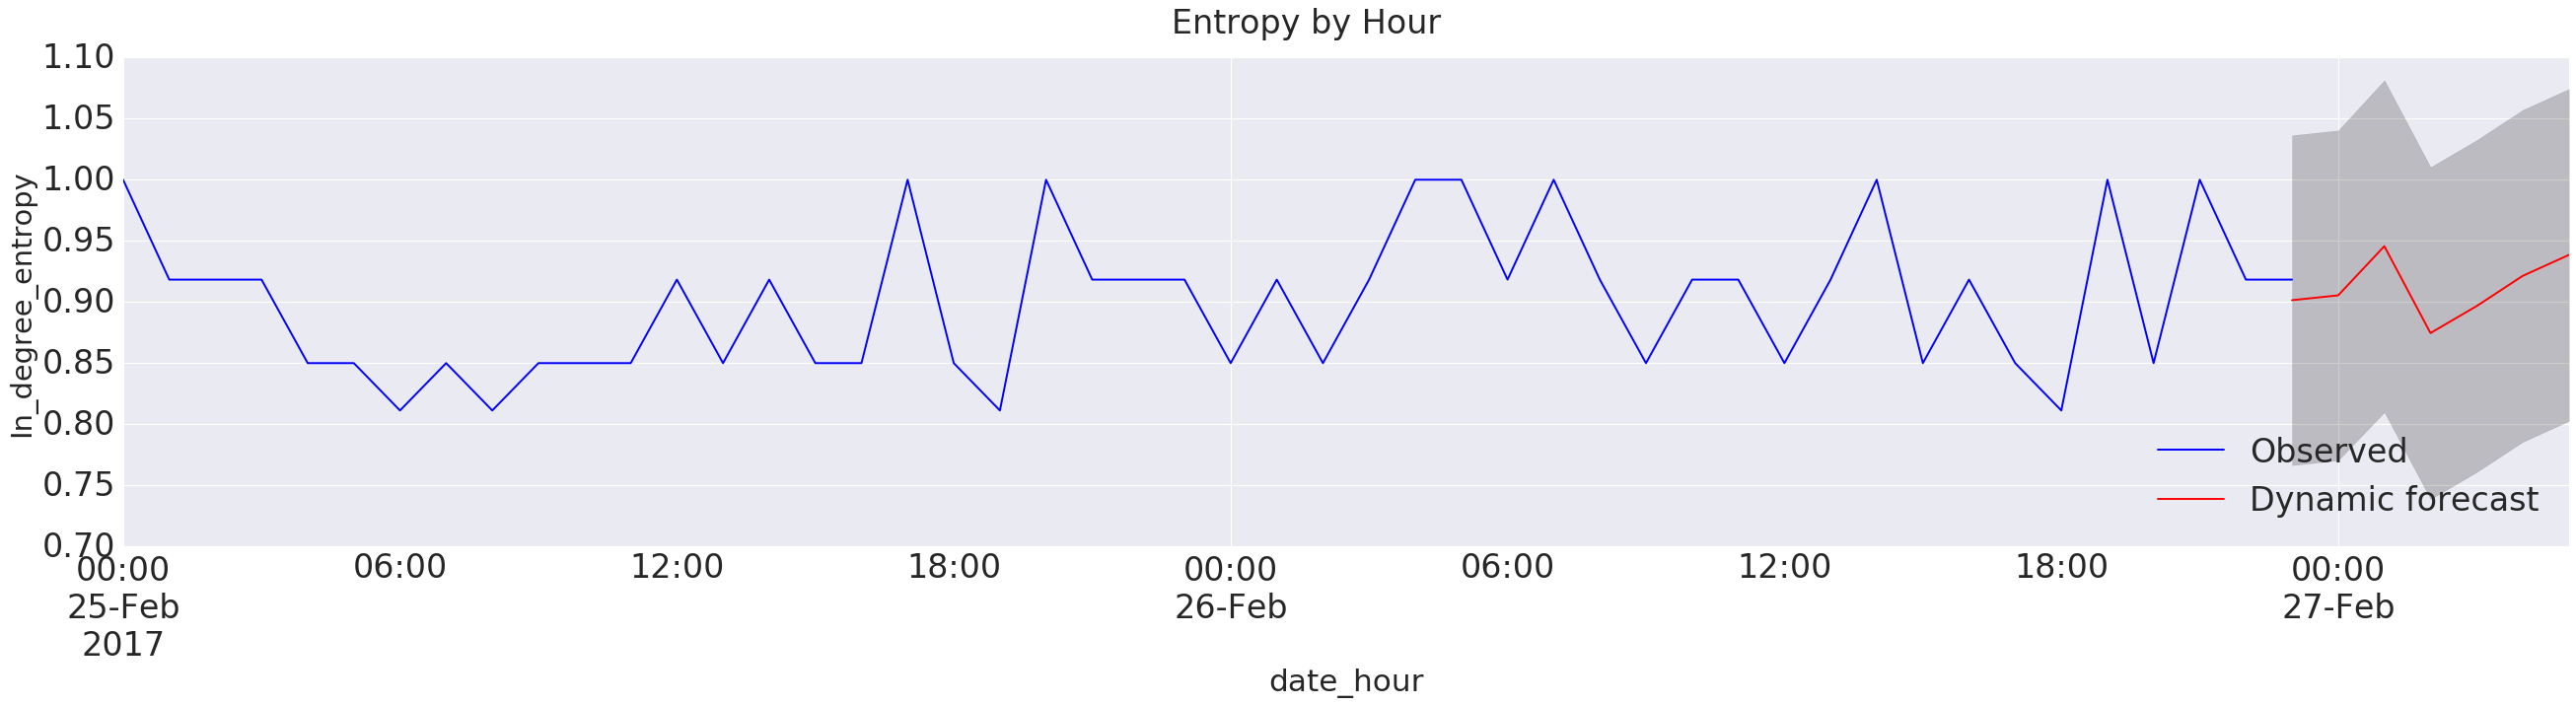

In [106]:

###################################################################################################
## Graphs both the Observed, In-Sample Predictions as well as Out-Of-Sample Forecasts and 
##  includes appropriate Confidence Intervals
## This is all controlled with the code block above using the constrained view of the C.I.'s
## These are Dynamic predictions
###################################################################################################

fig, ax = plt.subplots(figsize=(40,8))
npre = 4

fig.suptitle('Entropy by Hour', fontsize=30)
plt.xlabel('', fontsize=28)   # The fontsize here is applied to the df variable name not the label in the function
plt.ylabel('In_degree_entropy', fontsize=26)
plt.xticks(rotation='vertical')  

## Plot using different data ranges and formats of the data points
ent_calc_df1.ix['2017-02-25 00:00:00':'2017-02-27 05:00:00','In_degree_entropy'].plot(ax=ax, style='blue', label='Observed')  
#ent_calc_df1.ix[402:527,'In_degree_entropy'].plot(ax=ax, style='blue', label='Observed')  
#ent_calc_df1.ix[:,'In_degree_entropy'].plot(ax=ax, style='blue', label='Observed') 

## Plot predictions
# THIS RANGE IS SET ABOVE WHEN SETTING THE "predict.predicted_mean.ix" OBJECT ######
predicted_mean_1.ix[:].plot(ax=ax, style='red', label='Dynamic forecast', fontsize=30)

## Plot the Confidence Intervals 
#ci = predict_ci.ix['2017-02-26 23:00:00':'2017-02-27 10:00:00']
#ci = predict_ci.ix[402:527]
ci = predict_ci_1.ix[:]

ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='black', alpha=0.2)

legend = ax.legend(loc='lower right', fontsize=30)

#### Graph #2

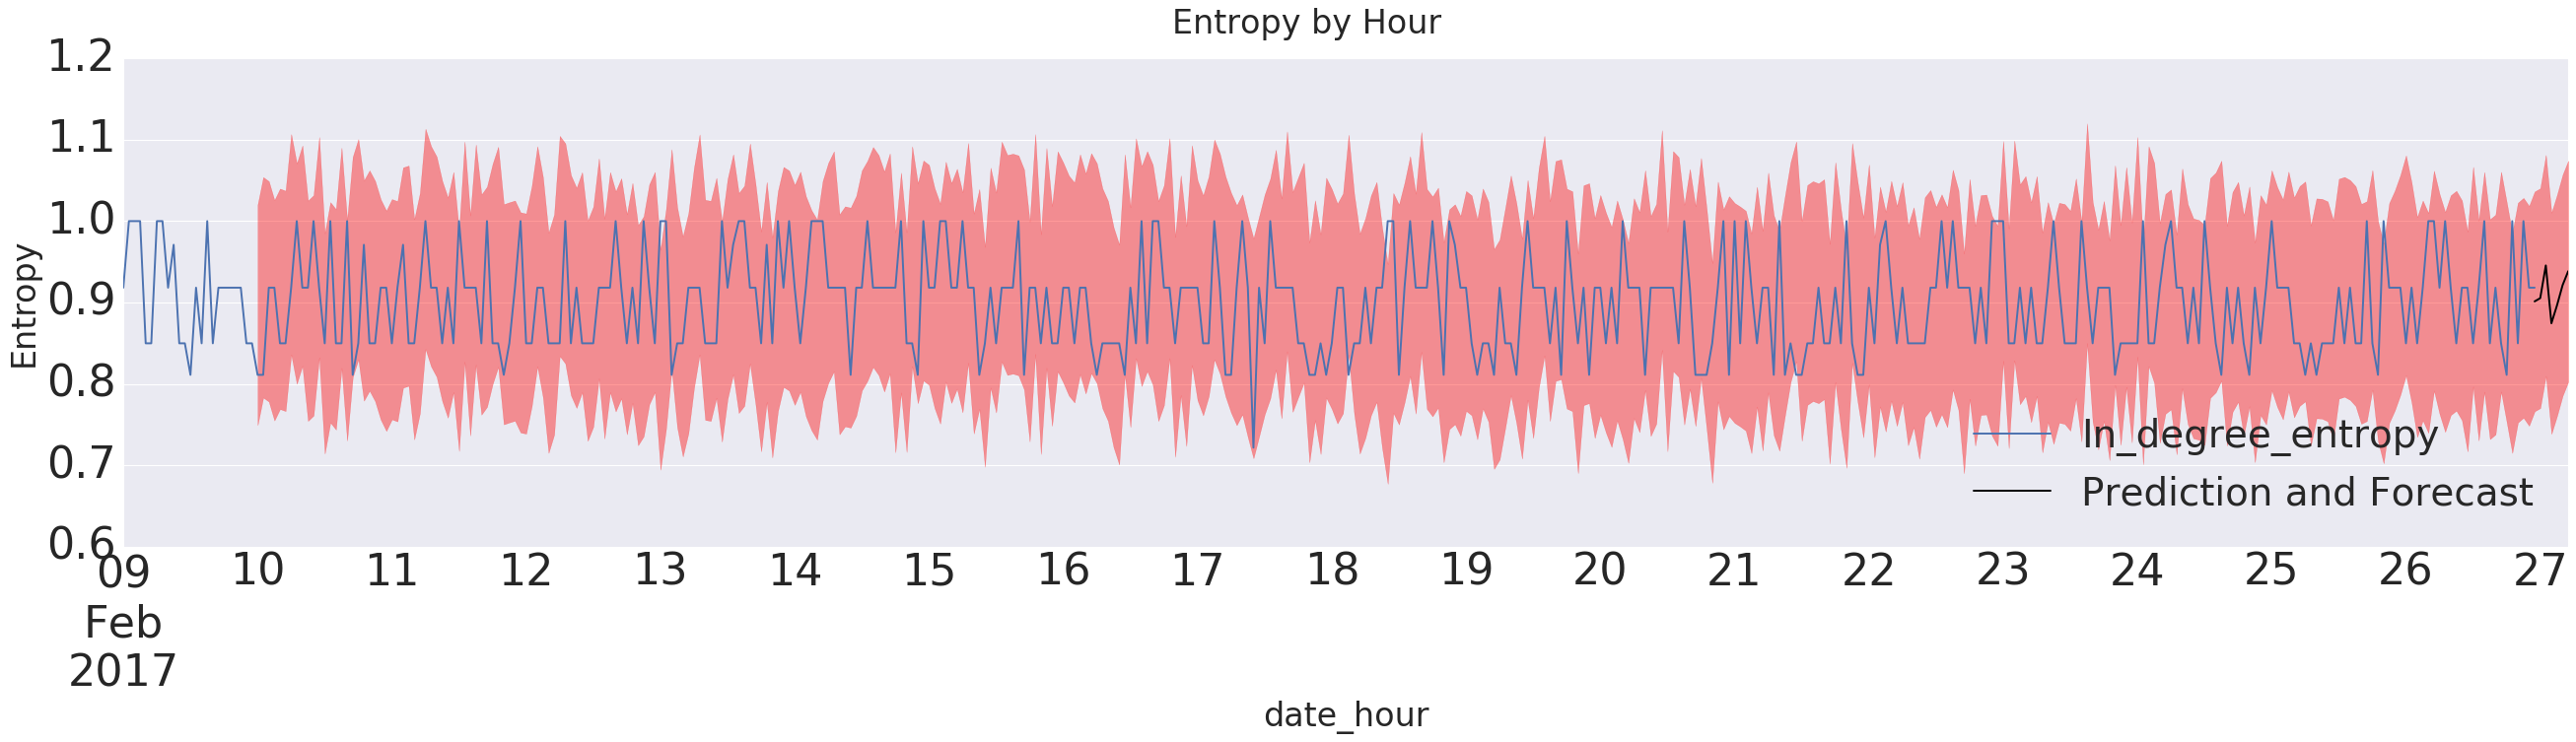

In [107]:
# Plot another graph to view a longer time interval for both Prediction and Forecasting

fig, ax = plt.subplots(figsize=(40, 8))
fig.suptitle('Entropy by Hour', fontsize=30)
plt.xlabel('date/hour',fontsize=30)
plt.ylabel('Entropy',fontsize=30)
ax = ent_calc_df1['In_degree_entropy'].ix['2017-02-09 00:00:00':'2017-02-26 23:00:00'].plot(ax=ax)   

predicted_mean_2.ix[:].plot(ax=ax, style='black', label='Prediction and Forecast', fontsize=40)
ci = predict_ci_2.ix[:]  # ci is the display labels and values for the Upper and Lower bounds 
## :,0 - Lower values by hour   
## :,1 - Upper values by hour
## alpha is transparency value.  Higher is less transparent
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.40)  

legend = ax.legend(loc='lower right',fontsize=35)